In [1]:
#### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from tqdm import tqdm
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

warnings.filterwarnings('ignore')

plt.rc('font', size=30)

In [5]:
means = (0.49139968, 0.48215841, 0.44653091)
stds = (0.24703223, 0.24348513, 0.26158784)

train_transforms = T.Compose(
    [
        T.RandomResizedCrop(size=32, scale=(0.8, 1.1)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomAdjustSharpness(sharpness_factor=2),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)


train_dataset = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=True, download=True, transform=train_transforms)
valid_dataset = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=False, download=True,transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 56098984.67it/s]


Extracting /home/jupyter/mnt/datasets/cifar10/cifar-10-python.tar.gz to /home/jupyter/mnt/datasets/cifar10
Files already downloaded and verified


In [6]:
def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [7]:
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [8]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [9]:
@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    preds = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        preds.append(output)
    return torch.cat(preds)

In [10]:
@torch.inference_mode()
def predict_tta(model: nn.Module, loader: DataLoader, device: torch.device, iterations: int = 2):
    model.eval()
    prediction = []

    for i in range(iterations):
        single_prediction = []
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            single_prediction.append(output)
        prediction.append(torch.cat(single_prediction))
     
    prediction = torch.stack(prediction).mean(dim=0)
    prediction = torch.argmax(prediction, dim=1)
    return prediction

In [ ]:
### Функция для сохранения предсказаний обученной модели

def save_data(preds, name):
    torch.save(preds, f'/kaggle/working/{name}')

In [11]:
def whole_train_valid_cycle_with_schedule(model, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []
    
    valid_accuracy = 0
    num_epochs = 0
    

    while valid_accuracy < 0.9:
        
        num_epochs += 1 
        
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            f'{title}, {num_epochs} epoch'
        )
        
        scheduler.step()

In [12]:
def create_advanced_conv_cifar():
    return nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 16 x 16 x 32
            nn.Dropout2d(p=0.2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 8 x 8 x 32
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 4 x 4 x 128
            nn.Dropout2d(p=0.2),

            nn.Flatten(),

            nn.Linear(4 * 4 * 128, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

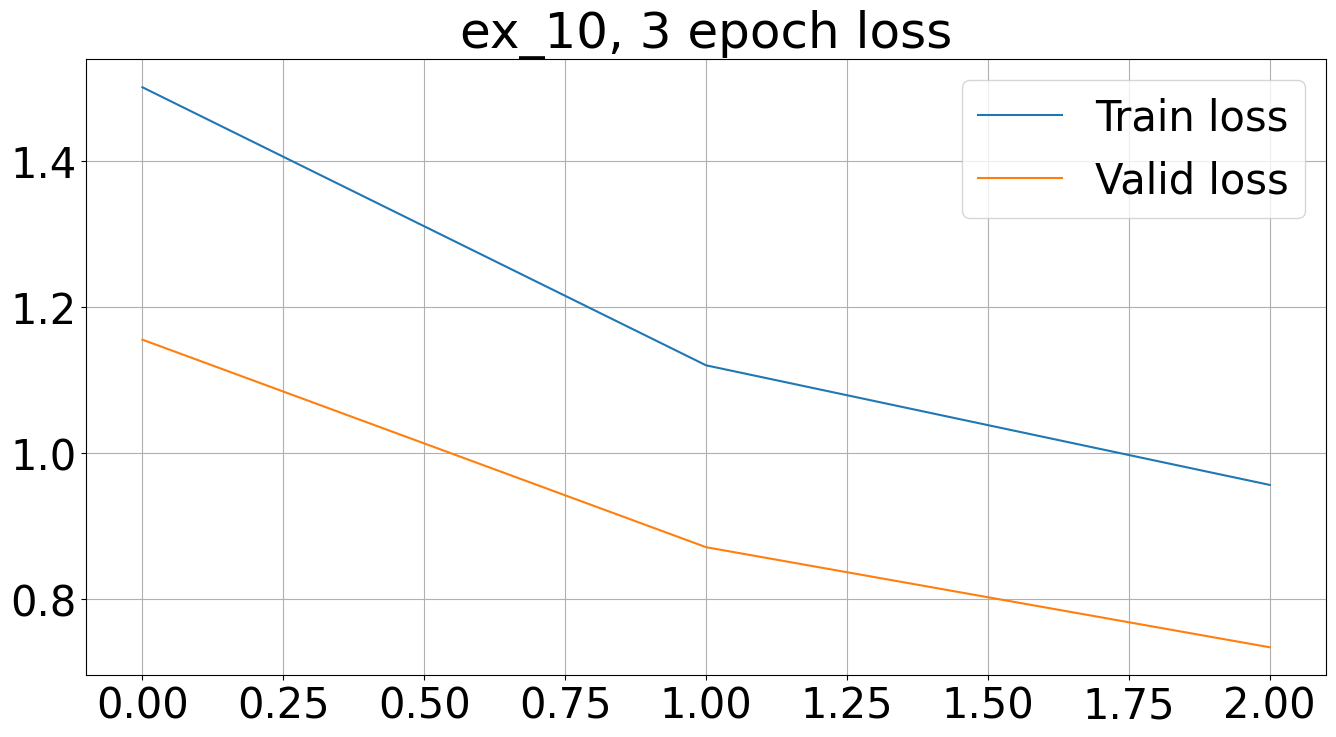

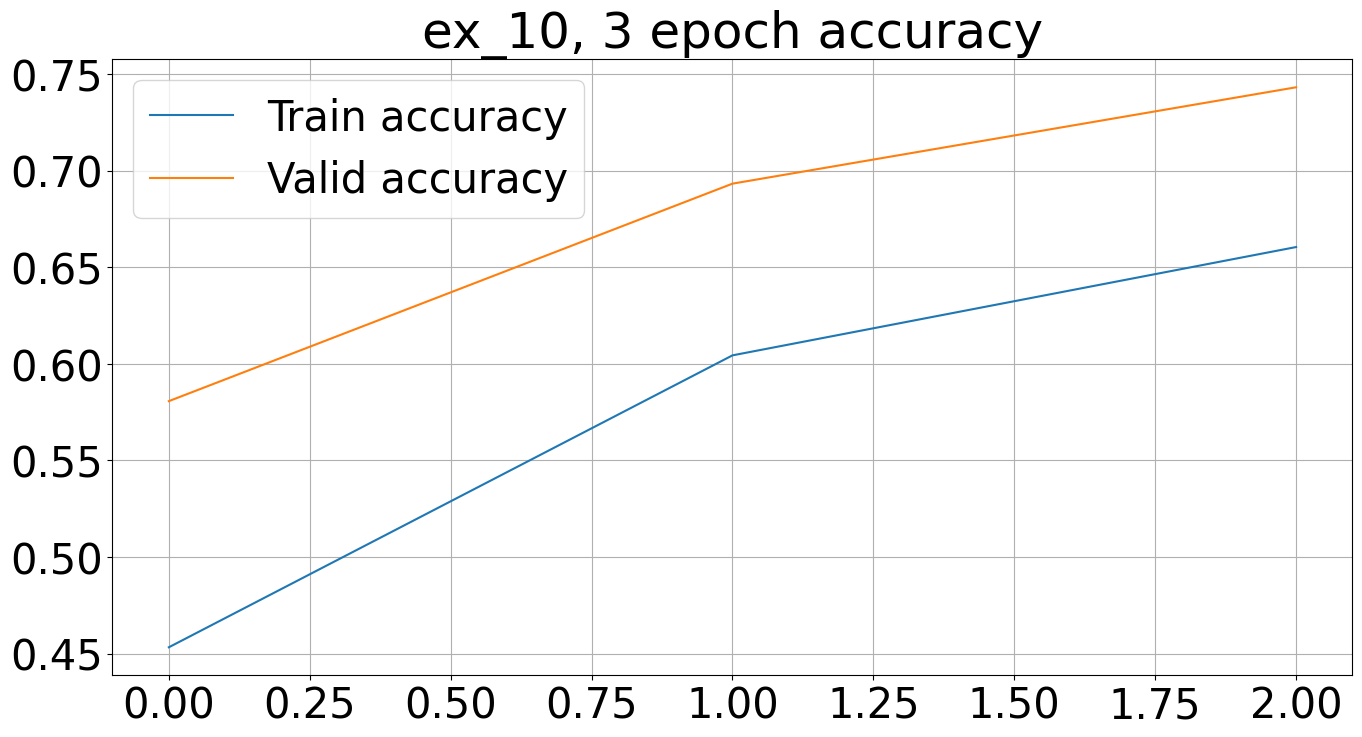

Train:  58%|█████▊    | 228/391 [01:37<01:07,  2.43it/s]

In [ ]:
device = torch.device('cpu')
model = create_advanced_conv_cifar().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=25)
loss_fn = nn.CrossEntropyLoss()

whole_train_valid_cycle_with_schedule(model, 'ex_10')

In [ ]:
preds = predict(model=model, loader=valid_loader, device=device)
preds_tta = predict_tta(model=model, loader=valid_loader, device=device)

save_data(preds, 'ex_10_preds')
save_data(preds_tta, 'ex_10_preds_tta')
save_data(model.state_dict(), 'ex_10_params')